# Part 1 - Data Preprocessing, and Descriptives

In [1]:
# Import all required Python modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, linalg

# Import custom sleep study code
import sys
sys.path.insert(0, '../lib')
import sleep_study_utils as ss

idx = pd.IndexSlice

/home/conor/.virtualenvs/cbs/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Display only 3 decimal points in tables
pd.options.display.float_format = '{:.3f}'.format

In [3]:
# List of all columns in the data frame that have scores
score_columns = ss.score_columns()

In [4]:
# Load the data
data = pd.read_pickle('../data/sleep_study_data.pickle.bz2')
data.info() # List all the columns in the data frame

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16812 entries, 12 to 89158
Data columns (total 20 columns):
age_at_test                    16812 non-null float64
gender                         16602 non-null category
education                      16471 non-null category
typical_sleep_duration         16288 non-null float64
prev_night_sleep_duration      13182 non-null float64
anxiety                        16714 non-null category
depression                     16771 non-null category
spatial_span_score             13474 non-null float64
grammatical_reasoning_score    13490 non-null float64
double_trouble_score           13563 non-null float64
odd_one_out_score              13455 non-null float64
monkey_ladder_score            13465 non-null float64
rotations_score                13463 non-null float64
feature_match_score            13486 non-null float64
digit_span_score               13465 non-null float64
spatial_tree_score             14431 non-null float64
paired_associates_scor

In [5]:
data = data[~data.index.duplicated(keep='first')] # Remove duplicate rows
data = data.drop(columns='odd_one_out_max')       # Remove unused score column
print("%d people completed the study"%data.shape[0])

16724 people completed the study


In [6]:
# Remove subjects reported older than 100 or younger than 10 years of age
data = data[(data['age_at_test'] <= 100) & (data['age_at_test'] >= 18)]
print("%d people remain after filtering for age"%data.shape[0])

# Remove subjects who reported sleep zero or more than 16 hours per night.
data = data[(data['typical_sleep_duration'] > 0) & (data['typical_sleep_duration'] <= 16)]
# data = data[(data['prev_night_sleep_duration'] > 0) & (data['prev_night_sleep_duration'] <= 16)]
print("%d people after filtering for sleep duration"%data.shape[0])

# Remove subject who are missing data in any column (i.e., any questionnaire response or test score)
data = data.dropna(axis=0, how='any')
print("%d people have data in all columns"%data.shape[0])

# In two passes, remove scores that are more than 6 then more than 4 standard deviations from the mean
data = ss.filter_df_with_stdevs(data, scores=score_columns, stdevs=[6])
print("%d people after 6 stdev filter"%data.shape[0])

data = ss.filter_df_with_stdevs(data, scores=score_columns, stdevs=[4])
print("%d people after 4 stdev filter"%data.shape[0])

data.describe()

15549 people remain after filtering for age
15035 people after filtering for sleep duration
11182 people have data in all columns
11128 people after 6 stdev filter
10886 people after 4 stdev filter


,age_at_test,typical_sleep_duration,prev_night_sleep_duration,spatial_span_score,grammatical_reasoning_score,double_trouble_score,odd_one_out_score,monkey_ladder_score,rotations_score,feature_match_score,digit_span_score,spatial_tree_score,paired_associates_score,polygons_score,token_search_score
count,10886.000,10886.000,10886.000,10886.000,10886.000,10886.000,10886.000,10886.000,10886.000,10886.000,10886.000,10886.000,10886.000,10886.000,10886.000
mean,41.689,6.410,6.860,5.614,17.522,23.498,10.184,7.656,74.045,112.167,6.566,17.982,4.632,39.998,7.024
std,14.254,1.273,1.678,1.072,5.465,15.684,3.656,1.192,36.702,31.683,1.396,10.584,0.998,22.567,2.292
min,18.000,0.100,0.000,2.000,-4.000,-17.000,-5.000,3.000,-39.000,-10.000,2.000,0.000,2.000,-22.000,0.000
25%,30.000,6.000,6.000,5.000,14.000,11.000,8.000,7.000,50.000,90.000,6.000,11.000,4.000,24.000,6.000
50%,40.000,6.500,7.000,6.000,18.000,26.000,11.000,8.000,73.000,110.000,7.000,17.000,5.000,39.000,7.000
75%,53.000,7.000,8.000,6.000,21.000,35.000,13.000,8.000,98.000,132.000,7.000,24.000,5.000,54.000,8.000
max,89.000,13.000,13.000,10.000,37.000,86.000,23.000,12.000,219.000,240.000,12.000,62.000,8.000,126.000,14.000


In [7]:
# Convert gender (stored as string) to M/F/Other categories
data.loc[:,'gender'] = data['gender'].cat.set_categories(['Male','Female','Other'])
data.loc[:,'gender'] = data['gender'].fillna('Other')

In [8]:
# Convert test scores to z-scores, calculate an "overall" score, and domain scores
all_test_scores   = data[score_columns].copy()
all_test_z_scores = all_test_scores.apply(stats.zscore)

# Calculate the three orthogonal domain scores using the factor loadings
domain_names  = [score+"_score" for score in ss.FACTOR_NAMES]
domain_scores = np.dot(all_test_z_scores, linalg.pinv(ss.FACTOR_LOADINGS).T)
for i, name in enumerate(domain_names):
    data.loc[:, name] = domain_scores[:, i]

# Calculate the Overall Score as the mean of all 12 test z-scores
# Then scale the Overall Score so that the population mean = 0 and stdev = 1.0
data.loc[:, 'Overall_score'] = all_test_z_scores.mean(axis=1)
data.loc[:, 'Overall_score'] = data[['Overall_score']].apply(stats.zscore)
domain_names  += ['Overall_score']
score_columns += domain_names

In [9]:
# Display the factor loadings (in a table for supplementary materials)
factor_loading_df = pd.DataFrame(ss.FACTOR_LOADINGS, index=ss.TEST_NAMES, columns=ss.FACTOR_NAMES)
factor_loading_df.to_excel('../CSVs/TableS3.xlsx')
factor_loading_df

,STM,Reasoning,Verbal
spatial_span,0.701,0.211,0.063
grammatical_reasoning,0.065,0.320,0.656
double_trouble,0.215,0.353,0.525
odd_one_out,0.199,0.553,-0.112
monkey_ladder,0.697,0.228,0.054
rotations,0.121,0.665,0.093
feature_match,0.167,0.550,0.219
digit_span,0.270,-0.205,0.709
spatial_tree,0.402,0.457,0.038
paired_associates,0.599,-0.030,0.234


In [10]:
score_summary = data[score_columns].describe().T
score_summary.index =  [score[:-6] for score in score_columns]
score_summary.to_excel('../CSVs/TableS4.xlsx')
score_summary

,count,mean,std,min,25%,50%,75%,max
spatial_span,10886.000,5.614,1.072,2.000,5.000,6.000,6.000,10.000
grammatical_reasoning,10886.000,17.522,5.465,-4.000,14.000,18.000,21.000,37.000
double_trouble,10886.000,23.498,15.684,-17.000,11.000,26.000,35.000,86.000
odd_one_out,10886.000,10.184,3.656,-5.000,8.000,11.000,13.000,23.000
monkey_ladder,10886.000,7.656,1.192,3.000,7.000,8.000,8.000,12.000
rotations,10886.000,74.045,36.702,-39.000,50.000,73.000,98.000,219.000
feature_match,10886.000,112.167,31.683,-10.000,90.000,110.000,132.000,240.000
digit_span,10886.000,6.566,1.396,2.000,6.000,7.000,7.000,12.000
spatial_tree,10886.000,17.982,10.584,0.000,11.000,17.000,24.000,62.000
paired_associates,10886.000,4.632,0.998,2.000,4.000,5.000,5.000,8.000


# Participant Descriptives

In [11]:
print("Number of people older than 70 years: %d"%data[data['age_at_test']>70].shape[0])

Number of people older than 70 years: 269


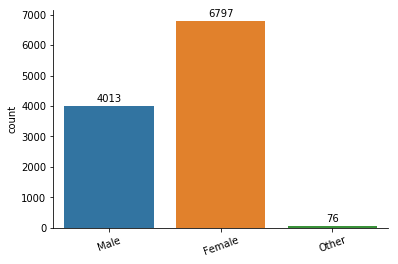

In [12]:
# Histogram and counts for gender categories
ss.create_histogram(data, 'gender')

In [13]:
# Re-order levels education (from least to most)
education_level_order = [ "None", "High School Diploma", "Bachelor's Degree",  "Master's Degree", "Doctoral or Professional Degree"]
data['education'] = data['education'].cat.reorder_categories(education_level_order, ordered=True)

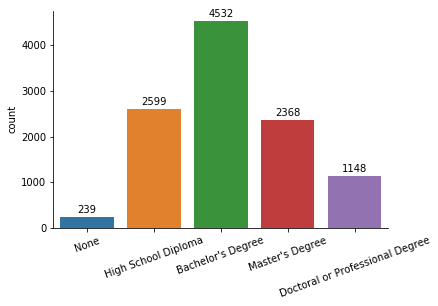

In [14]:
# Get counts for each level of education 
ss.create_histogram(data, 'education')

In [15]:
# Re-order the categories representing frequency of anxiety-related episodes (least to most)
anxiety_level_order = ['Not during the past month', 'Less than once a week', 'Once or twice a week', 'Three or more times a week', 'Every day']
data['anxiety'] = data['anxiety'].cat.reorder_categories(anxiety_level_order, ordered=True)

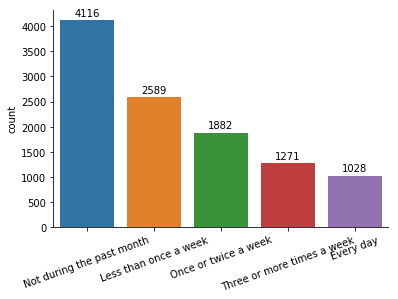

In [16]:
# Get the counts for the frequency of anxiety-related episodes
ss.create_histogram(data, 'anxiety')

In [17]:
# Re-order the frequency of depressive episodes (least to most)
depression_level_order = ['Not during the past month', 'Less than once a week', 'Once or twice a week', 'Three or more times a week', 'Every day']
data['depression'] = data['depression'].cat.reorder_categories(depression_level_order, ordered=True)

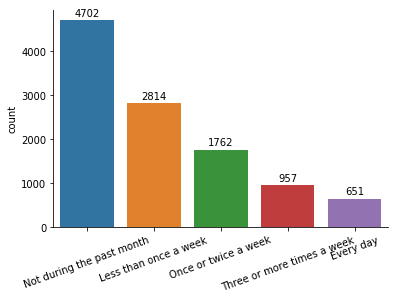

In [18]:
ss.create_histogram(data, 'depression')

In [19]:
# Table of responses to each questionnaire item
demo_questions = ['gender', 'education', 'anxiety', 'depression']
demo_index     = [(question,category) for question in demo_questions for category in data[question].unique()]
demo_index     = pd.MultiIndex.from_tuples(demo_index)
demographics   = pd.DataFrame(index=demo_index, columns=['count'])
for question in demo_questions:
    demographics.loc[idx[question, :], 'count'] = data[question].value_counts().values
demographics.to_excel('../CSVs/TableS1.xlsx')

In [20]:
demographics

count
gender     Male                              6797
           Female                            4013
           Other                               76
education  High School Diploma               4532
           Master's Degree                   2599
           Bachelor's Degree                 2368
           Doctoral or Professional Degree   1148
           None                               239
anxiety    Less than once a week             4116
           Once or twice a week              2589
           Not during the past month         1882
           Every day                         1271
           Three or more times a week        1028
depression Less than once a week             4702
           Once or twice a week              2814
           Not during the past month         1762
           Three or more times a week         957
           Every day                          651

## Other Variables

In [21]:
# Load the optional questionnaire data, select only rows (subjects)
# that correspond to participants in the final sample.
other_qs = pd.read_pickle('../data/other_questionnaire.pickle.bz2')
other_qs = other_qs.reindex(data.index)
other_qs = other_qs.reset_index()

In [22]:
# Responses may be stored as "multi-select" (i.e., comma separated options)
# like "english,french,spanish". So, break those apart and store each as a
# new response with the user's ID.
for q in ['country_of_origin', 'languages_spoken']:
    for index, row in other_qs.iterrows():
        if type(row[q]) is str and "," in row[q]:
            answers = row[q].split(',')
            row = row.to_frame().T
            new_rows = pd.concat([row]*len(answers), ignore_index=True)
            new_rows.loc[:,q] = answers
            other_qs = pd.concat([other_qs,new_rows], ignore_index=True)
            other_qs.loc[row.index,q] = np.nan

In [23]:
# Tally the counts of languages and countries, but pool responses to 
# options that less than 1% of people selected into an "other" category.
response_threshold = data.shape[0]*.01 # 1% of our final sample size

# Language(s) spoken at home
language_counts = other_qs['languages_spoken'].value_counts()
languages_rarely_chosen = language_counts[language_counts<response_threshold]
other_response_count = pd.Series(data=[languages_rarely_chosen.sum()], index=['other'])
languages_frequently_chosen = language_counts[language_counts>response_threshold]
language_counts = languages_frequently_chosen.append(other_response_count)
language_counts.name = "What language(s) do you primarily speak at home?"
print("'Other' languages include %d possible options"%languages_rarely_chosen.size)

# Country (countries) they grew up in
country_counts = other_qs['country_of_origin'].value_counts()
countries_rarely_chosen = country_counts[country_counts<response_threshold]
other_response_count = pd.Series(data=[countries_rarely_chosen.sum()], index=['other'])
countries_frequently_chosen = country_counts[country_counts>response_threshold]
country_counts = countries_frequently_chosen.append(other_response_count)
country_counts.name = "What country (or countries) did you grow up in?"
print("'Other' countries include %d possible options"%countries_rarely_chosen.size)

'Other' languages include 73 possible options
'Other' countries include 159 possible options


In [24]:
# Create a dataframe to save as an .xlsx
index_levels = [(q.name, a) for q in [language_counts, country_counts] for a in q.index.values]
index_levels = pd.MultiIndex.from_tuples(index_levels)
other_q_results = pd.DataFrame(index=index_levels, columns=['N'])
other_q_results.loc[:,'N'] = pd.concat([language_counts, country_counts], axis=0).values
other_q_results.to_excel('../CSVs/country_languages.xlsx')
other_q_results

N
What language(s) do you primarily speak at home? English                                             10314
                                                 French                                                778
                                                 Portuguese                                            637
                                                 Spanish                                               338
                                                 German                                                194
                                                 Russian                                               167
                                                 Cantonese                                             127
                                                 Danish                                                119
                                                 other                                                1730
What country (or countries) did you grow up in?  United Kingdom of Great Britain and Northern Ir...   4286
                                                 Canada                                               4220
                                                 United States of America                             1037
                                                 Portugal                                              678
                                                 India                                                 285
                                                 Germany                                               260
                                                 Australia                                             246
                                                 Denmark                                               166
                                                 France                                                161
                                                 Ireland                                               141
                                                 New Zealand                                           136
                                                 Italy                                                 132
                                                 Netherlands                                           131
                                                 Pakistan                                              114
                                                 other                                                2883

## Distribution and Scatter Plots of Age & Sleep Durations

/home/conor/.virtualenvs/cbs/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


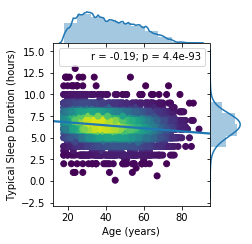

In [25]:
f1a = ss.joint_plot_with_data_cloud(data, 'age_at_test', 'typical_sleep_duration', 'Age (years)', 'Typical Sleep Duration (hours)')
f1a.savefig('../images/Figure_1a.pdf', format='pdf')

/home/conor/.virtualenvs/cbs/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


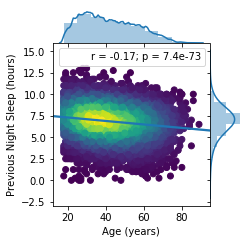

In [26]:
f1b = ss.joint_plot_with_data_cloud(data, 'age_at_test', 'prev_night_sleep_duration', 'Age (years)', 'Previous Night Sleep (hours)')
f1b.savefig('../images/Figure_1b.pdf', format='pdf')

/home/conor/.virtualenvs/cbs/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


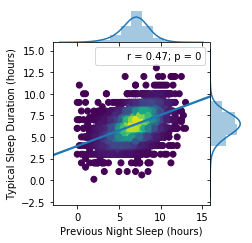

In [27]:
f1c = ss.joint_plot_with_data_cloud(data, 'prev_night_sleep_duration', 
                                          'typical_sleep_duration',
                                          'Previous Night Sleep (hours)',
                                          'Typical Sleep Duration (hours)', )
f1c.savefig('../images/Figure_1c.pdf', format='pdf')

### Save the final sample data (used in subsequent analysis)

In [28]:
data.to_pickle('../data/final_sample.pickle.bz2')